In [1]:
from IPython import display
import random
import numpy as np
import torch
import pickle
import timeit
import time
import argparse
import pprint
from pathlib import Path
from confs import fln, fln2, Logistic
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
import numpy.random as npr
from utilsNew import *

In [2]:
import matplotlib.pyplot as plt
import pickle

In [3]:
cudaid = 3
torch.cuda.set_device(cudaid)
torch.manual_seed(0) # cpu
torch.cuda.manual_seed(0) #gpu
np.random.seed(0) #numpy
random.seed(0) #random and transforms
torch.backends.cudnn.deterministic=True # cudnn

In [4]:
cuda = torch.cuda.is_available()
if cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [5]:
def emfRun(R, CT, Cb, etaT, etab, maxIter=100, is_plot=False, is_showPro=False):
    LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    
    
    Ynew = Y.clone()
    Rb = (1-R.to_dense()).to_sparse()
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaErrs = []
    bThetaErrs = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        
        # estimate Y at current parameters
        Yhat = X.to_dense().matmul(betaOld) + bThetaOld
        eprobs = Logistic(Yhat)
        # impute the missing terms with estimated value
        Ynew[Rb.to_dense().bool()] = eprobs[Rb.to_dense().bool()] 
        
        
        t0 = time.time()
        LvNow = emLossL(bThetaOld, betaOld, f, X, Ynew, is_logf=False)
        t1 = time.time()
       
        # update beta
        LpbvOld = emLossLpb(bThetaOld, betaOld, conDenfs[:3], X, Ynew)
        betaNewRaw = betaOld - etab * LpbvOld
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        LpTvOld = emLossLpT(bThetaOld, betaNew, conDenfs[:3], X, Ynew)
        t3 = time.time()
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=10) # it can be very  fast
        U, S, V =  svdres
        softS = (S-LamT*etaT).clamp_min(0)
        bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, softS, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaErrs.append((betaNew-beta0).norm().item())
        bThetaErrs.append((bThetaNew-bTheta0).norm().item())
        betaL0s.append(len(torch.nonzero(betaNew)))
        #bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 10])
            
            plt.subplot(231)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            plt.subplot(232)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Beta Err")
            betaErrsArr = np.log(np.array(betaErrs))
            plt.plot(list(range(0, t+1)), betaErrsArr)
            plt.scatter(t, betaErrsArr[-1], color="red", s=20)
            plt.text(t, betaErrsArr[-1], f"Error is {np.exp(betaErrsArr[-1]):.3e}")
            
            plt.subplot(233)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Theta Err")
            bThetaErrsArr = np.log(np.array(bThetaErrs))
            plt.plot(list(range(0, t+1)), bThetaErrsArr)
            plt.scatter(t, bThetaErrsArr[-1], color="red", s=20)
            plt.text(t, bThetaErrsArr[-1], f"Error is {np.exp(bThetaErrsArr[-1]):.3e}")
            
            plt.subplot(235)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #plt.subplot(236)
            #plt.xlim([0, maxIter])
            ##plt.ylim([0, np.min([n, m])])
            #plt.title("Theta Rank")
            #plt.plot(list(range(0, t+1)), bThetaRanks)
            #plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            #plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            #plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["betaErrs"] = betaErrs
    res["bThetaErrs"] = bThetaErrs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    #res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [6]:
def marfRun(R, CT, Cb, etaT, etab, maxIter=100, is_plot=False, is_showPro=False):
    LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaErrs = []
    bThetaErrs = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        t0 = time.time()
        #LvNow = marLinearLossL(X, Y, R, bThetaOld, betaOld, sigma=sigmaY) 
        LvNow = marLossL(bThetaOld, betaOld, f, X, Y, R, is_logf=False)
        t1 = time.time()
       
        # update beta
        LpbvOld = marLossLpb(bThetaOld, betaOld, conDenfs[:3], X, Y, R)
        betaNewRaw = betaOld - etab * LpbvOld
        #betaNewRaw = marLinearUpdateBeta(X, Y, R, bThetaOld)
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        LpTvOld = marLossLpT(bThetaOld, betaNew, conDenfs[:3], X, Y, R)
        #bThetaNewRaw = marLinearUpdateTheta(X, Y, R, bThetaOld, betaNew)
        t3 = time.time()
        #svdres = torch.svd(bThetaNewRaw)
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=10) # it can be very  fast
        #svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        U, S, V =  svdres
        softS = (S-LamT*etaT).clamp_min(0)
        bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, softS, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaErrs.append((betaNew-beta0).norm().item())
        bThetaErrs.append((bThetaNew-bTheta0).norm().item())
        betaL0s.append(len(torch.nonzero(betaNew)))
        #bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 10])
            
            plt.subplot(231)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            plt.subplot(232)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Beta Err")
            betaErrsArr = np.log(np.array(betaErrs))
            plt.plot(list(range(0, t+1)), betaErrsArr)
            plt.scatter(t, betaErrsArr[-1], color="red", s=20)
            plt.text(t, betaErrsArr[-1], f"Error is {np.exp(betaErrsArr[-1]):.3e}")
            
            plt.subplot(233)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Theta Err")
            bThetaErrsArr = np.log(np.array(bThetaErrs))
            plt.plot(list(range(0, t+1)), bThetaErrsArr)
            plt.scatter(t, bThetaErrsArr[-1], color="red", s=20)
            plt.text(t, bThetaErrsArr[-1], f"Error is {np.exp(bThetaErrsArr[-1]):.3e}")
            
            plt.subplot(235)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(236)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("Theta Rank")
            plt.plot(list(range(0, t+1)), bThetaRanks)
            plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["betaErrs"] = betaErrs
    res["bThetaErrs"] = bThetaErrs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    #res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [7]:
def fRun(R, CT, Cb, etaT, etab, maxIter=100, is_plot=False, is_showPro=False):
    LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaErrs = []
    bThetaErrs = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        t0 = time.time()
        LvNow = lossLBern(bThetaOld, betaOld, f, X, Y, R, probs=prob, fct=fct, is_logf=False)
        
        t1 = time.time()
        # update beta
        LpbvOld = lossLpbBern(bThetaOld, betaOld, conDenfs[:3], X, Y, R, probs=prob, fct=fct)
        betaNewRaw = betaOld - etab * LpbvOld
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        LpTvOld = lossLpTBern(bThetaOld, betaNew, conDenfs[:3], X, Y, R, probs=prob, fct=fct)
       
        t3 = time.time()
        # update Theta
        #svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=10) # it can be very  fast
        U, S, V =  svdres
        softS = (S-LamT*etaT).clamp_min(0)
        bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, softS, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaErrs.append((betaNew-beta0).norm().item())
        bThetaErrs.append((bThetaNew-bTheta0).norm().item())
        betaL0s.append(len(torch.nonzero(betaNew)))
        #bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 10])
            
            plt.subplot(231)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            plt.subplot(232)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Beta Err")
            betaErrsArr = np.log(np.array(betaErrs))
            plt.plot(list(range(0, t+1)), betaErrsArr)
            plt.scatter(t, betaErrsArr[-1], color="red", s=20)
            plt.text(t, betaErrsArr[-1], f"Error is {np.exp(betaErrsArr[-1]):.3e}")
            
            plt.subplot(233)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Theta Err")
            bThetaErrsArr = np.log(np.array(bThetaErrs))
            plt.plot(list(range(0, t+1)), bThetaErrsArr)
            plt.scatter(t, bThetaErrsArr[-1], color="red", s=20)
            plt.text(t, bThetaErrsArr[-1], f"Error is {np.exp(bThetaErrsArr[-1]):.3e}")
            
            plt.subplot(235)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            # plt.subplot(236)
            # plt.xlim([0, maxIter])
            # #plt.ylim([0, np.min([n, m])])
            # plt.title("Theta Rank")
            # plt.plot(list(range(0, t+1)), bThetaRanks)
            # plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            # plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            # plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["betaErrs"] = betaErrs
    res["bThetaErrs"] = bThetaErrs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    #res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [8]:
def genR3(Y):
    probs = torch.zeros(Y.shape)
    probs[Y==1] = 0.81 # missing rate 
    probs[Y==0] = 0.99 # missing rate
    ranUnif = torch.rand_like(probs)
    R = probs <= ranUnif
    return R.to_sparse().double()

In [9]:

n = m = 100
p = 2
prob = 0.2

In [9]:
n = m = 100
p = 2
prob = 0.2


# generate the parameters
beta0 = torch.tensor([1.0, -2.0])
bTheta0 = genbTheta(n, m, sigVs=np.array([50, 9, 8, 7, 6])*10)/50
initbetapref = 1 + (torch.rand(p)-1/2)/1 #[0.875, 1.125]
initthetapref = 1 + (torch.rand(n, m)-1/2)/4
betainit = beta0 * initbetapref
bThetainit = bTheta0 * initthetapref

X = genXBin(n, m, p, prob=prob) 
Y = genYlogit(X.to_dense(), bTheta0, beta0)
R = genR3(Y)
R.to_dense().double().mean()

tensor(0.0949)

In [10]:
conDenfs = [fln, fln2, fln2]
f = fln
f2 = fln2

In [11]:
tol = 1e-6
tolT = 0
tolb = 0

In [12]:
TErr = lambda x: np.linalg.norm(x["bTheta"]-bTheta0.cpu().numpy())
BErr = lambda x: np.linalg.norm(x["beta"]-beta0.cpu().numpy())
TRank = lambda x: x["bThetaRank"]
BL0Norm = lambda x: x["betaNorm0"]

### test for 10 reps

In [57]:
optParasMNAR = {}
optParasMNAR[100] = [1e-3, 0,  1e2, 5e2] 
optParasMNAR[200] = [1e-3, 0,  1e2, 5e2]
optParasMNAR[400] = [1e-3, 0,  1e2, 5e2]
optParasMNAR[800] = [1e-3, 0,  1e2, 5e2] # 800
optParasMNAR[1600] = [1e-3, 0,  1e2, 5e2] # 1600
optParasMNAR[3200] = [1e-3, 0,  1e2, 5e2] # 3200
optParasMNAR[6400] = [1e-3, 0,  1e2, 5e2] #6400

optParasMAR = {}
optParasMAR[100] = [1e-3, 0,  1e2, 2.5] 
optParasMAR[200] = [1e-3, 0,  1e2, 2.2] 
optParasMAR[400] = [1e-3, 0,  1e2, 1.5] 
optParasMAR[800] = [1e-3, 0,  1e2, 1] #800
optParasMAR[1600] = [1e-3, 0,  1e2, 0.5] #1600
optParasMAR[3200] = [1e-3, 0,  1e2, 0.1] #3200
optParasMAR[6400] = [1e-3, 0,  1e2, 0.1] # 6400

optParasEM = {}
optParasEM[100] = [1e-3, 0,  1.1*1e2, 0.5]
optParasEM[200] = [1e-3, 0,  0.98*1e2, 0.5]
optParasEM[400] = [1e-3, 0,  0.98*1e2, 0.3] 
optParasEM[800] = [1e-3, 0,  0.98*1e2, 0.2] #800
optParasEM[1600] = [1e-3, 0,  0.98*1e2, 0.1] #1600
optParasEM[3200] = [1e-3, 0,  1.1*1e2, 0.1] #3200
optParasEM[6400] = [1e-3, 0,  1.1*1e2, 0.1] #6400

In [55]:
fct = 1
for n in [100]:
    m = n
    
    beta0 = torch.tensor([1.0, -2.0])
    bTheta0 = genbTheta(n, m, sigVs=np.array([50, 9, 8, 7, 6])*10)/50
    
    ressMAR = []
    ressEM = []
    ressMNAR = []
    paraXEM = optParasEM[n]
    paraXMAR = optParasMAR[n]
    paraXMNAR = optParasMNAR[n]
    for j in tqdm(range(10)):
        initbetapref = 1 + (torch.rand(p)-1/2)/4  
        initthetapref = 1 + (torch.rand(n, m)-1/2)/4
        betainit = beta0 * initbetapref
        bThetainit = bTheta0 * initthetapref
        X = genXBin(n, m, p, prob=prob) 
        Y = genYlogit(X.to_dense(), bTheta0, beta0)
        R = genR3(Y)
        resEM = emfRun(R, CT=paraXEM[0], Cb=paraXEM[1], etaT=paraXEM[2], etab=paraXEM[3], maxIter=100, is_plot=0, is_showPro=0)
        resMAR = marfRun(R, CT=paraXMAR[0], Cb=paraXMAR[1], etaT=paraXMAR[2], etab=paraXMAR[3], maxIter=100, is_plot=0, is_showPro=0)
        resMNAR = fRun(R, CT=paraXMNAR[0], Cb=paraXMNAR[1], etaT=paraXMNAR[2], etab=paraXMNAR[3], maxIter=100, is_plot=0, is_showPro=0)
        ressMNAR.append((np.linalg.norm(beta0.cpu().numpy()-resMNAR["beta"]), np.linalg.norm(bTheta0.cpu().numpy()-resMNAR["bTheta"])))
        ressMAR.append((np.linalg.norm(beta0.cpu().numpy()-resMAR["beta"]), np.linalg.norm(bTheta0.cpu().numpy()-resMAR["bTheta"])))
        ressEM.append((np.linalg.norm(beta0.cpu().numpy()-resEM["beta"]), np.linalg.norm(bTheta0.cpu().numpy()-resEM["bTheta"])))


  0%|          | 0/10 [00:00<?, ?it/s]

In [148]:
print(f"The n is {n}! and para is {optParasMAR[n]} and {optParasEM[n]}")
print(np.array(ressMAR).mean(axis=0), np.array(ressEM).mean(axis=0))

The n is 6400! and para is [0.001, 0, 100.0, 0.1] and [0.001, 0, 110.00000000000001, 0.1]
[0.1468373  0.17840715] [0.14717627 0.15409447]


In [111]:
print(f"The n is {n}! and para is {optParasMNAR[n]}")
np.array(ressMNAR).mean(axis=0)

The n is 6400! and para is [0.001, 0, 100.0, 500.0]


array([0.0051086 , 0.07588549])

# SIMU

In [13]:
optParasMNAR = {}
optParasMNAR[100] = [1e-3, 0,  1e2, 5e2] 
optParasMNAR[200] = [1e-3, 0,  1e2, 5e2]
optParasMNAR[400] = [1e-3, 0,  1e2, 5e2]
optParasMNAR[800] = [1e-3, 0,  1e2, 5e2] # 800
optParasMNAR[1600] = [1e-3, 0,  1e2, 5e2] # 1600
optParasMNAR[3200] = [1e-3, 0,  1e2, 5e2] # 3200
optParasMNAR[6400] = [1e-3, 0,  1e2, 5e2] #6400
optParasMNAR[12800] = [1e-3, 0,  1e2, 5e2] #6400

optParasMAR = {}
optParasMAR[100] = [1e-3, 0,  1e2, 2.5] 
optParasMAR[200] = [1e-3, 0,  1e2, 2.2] 
optParasMAR[400] = [1e-3, 0,  1e2, 1.5] 
optParasMAR[800] = [1e-3, 0,  1e2, 1] #800
optParasMAR[1600] = [1e-3, 0,  1e2, 0.5] #1600
optParasMAR[3200] = [1e-3, 0,  1e2, 0.1] #3200
optParasMAR[6400] = [1e-3, 0,  1e2, 0.1/2] # 6400
optParasMAR[12800] = [1e-3, 0,  1e2, 0.1/2] # 6400

optParasEM = {}
optParasEM[100] = [1e-3, 0,  1.1*1e2, 0.8]
optParasEM[200] = [1e-3, 0,  0.98*1e2, 0.6]
optParasEM[400] = [1e-3, 0,  0.98*1e2, 0.4] 
optParasEM[800] = [1e-3, 0,  0.98*1e2, 0.3] #800
optParasEM[1600] = [1e-3, 0,  0.98*1e2, 0.2] #1600
optParasEM[3200] = [1e-3, 0,  1*1e2, 0.1] #3200
optParasEM[6400] = [1e-3, 0,  1*1e2, 0.1/2] #6400
optParasEM[12800] = [1e-3, 0,  1*1e2, 0.1/2] #6400

In [14]:
fct = 1
for n in [12800]:
    m = n
    if n == 12800:
        fct = 20
    
    beta0 = torch.tensor([1.0, -2.0])
    bTheta0 = genbTheta(n, m, sigVs=np.array([50, 9, 8, 7, 6])*10)/50
    
    ressMAR = []
    ressEM = []
    ressMNAR = []
    paraXEM = optParasEM[n]
    paraXMAR = optParasMAR[n]
    paraXMNAR = optParasMNAR[n]
    for j in tqdm(range(50)):
        initbetapref = 1 + (torch.rand(p)-1/2)/4  
        initthetapref = 1 + (torch.rand(n, m)-1/2)/4
        betainit = beta0 * initbetapref
        bThetainit = bTheta0 * initthetapref
        X = genXBin(n, m, p, prob=prob) 
        Y = genYlogit(X.to_dense(), bTheta0, beta0)
        R = genR3(Y)
        
        try:
            resEM = emfRun(R, CT=paraXEM[0], Cb=paraXEM[1], etaT=paraXEM[2], etab=paraXEM[3], maxIter=100, is_plot=0, is_showPro=0)
            resMAR = marfRun(R, CT=paraXMAR[0], Cb=paraXMAR[1], etaT=paraXMAR[2], etab=paraXMAR[3], maxIter=100, is_plot=0, is_showPro=0)
            resMNAR = fRun(R, CT=paraXMNAR[0], Cb=paraXMNAR[1], etaT=paraXMNAR[2], etab=paraXMNAR[3], maxIter=100, is_plot=0, is_showPro=0)
            
        except RuntimeError:
            pass
            del X, Y, R, betainit, bThetainit, initbetapref, initthetapref
        else:
            ressMNAR.append((np.linalg.norm(beta0.cpu().numpy()-resMNAR["beta"]), np.linalg.norm(bTheta0.cpu().numpy()-resMNAR["bTheta"])))
            ressMAR.append((np.linalg.norm(beta0.cpu().numpy()-resMAR["beta"]), np.linalg.norm(bTheta0.cpu().numpy()-resMAR["bTheta"])))
            ressEM.append((np.linalg.norm(beta0.cpu().numpy()-resEM["beta"]), np.linalg.norm(bTheta0.cpu().numpy()-resEM["bTheta"])))
            del resEM, resMNAR, resMAR, X, Y, R, betainit, bThetainit, initbetapref, initthetapref
            
    # with open(f"./JMLRR2_linearSmallp_n{n}.pkl", "rb") as rf:
    #      oldRes = pickle.load(rf)
    
    ressDic = {}
    ressDic["ressEM"] = ressEM
    ressDic["ressMAR"] = ressMAR
    ressDic["ressMNAR"] = ressMNAR
    #ressDic["ressEM"] = oldRes["ressEM"]
    #ressDic["ressMAR"] = oldRes["ressMAR"]
    #ressDic["ressMNAR"] = oldRes["ressMNAR"]
    ressDic["beta0"] = beta0
    ressDic["bTheta0"] = bTheta0
    with open(f"./JMLRR2_logiSmallp_n{n}.pkl", "wb") as wf:
        pickle.dump(ressDic, wf)

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
errssMARs = []
errssEMs = []
errssMNARs = []
ns = [100, 200, 400, 800, 1600, 3200, 6400, 12800]
for n in ns:
    with open(f"./JMLRR2_logiSmallp_n{n}.pkl", "rb") as rf:
        ressDic = pickle.load(rf)
        
    errssMARs.append(np.array(ressDic["ressMAR"]))
    errssMNARs.append(np.array(ressDic["ressMNAR"]))
    errssEMs.append(np.array(ressDic["ressEM"]))
        

In [19]:
errEMmean =  np.array([res.mean(axis=0) for res in errssEMs])
errMARmean =  np.array([res.mean(axis=0) for res in errssMARs])
errMNARmean = np.array([res.mean(axis=0) for res in errssMNARs])

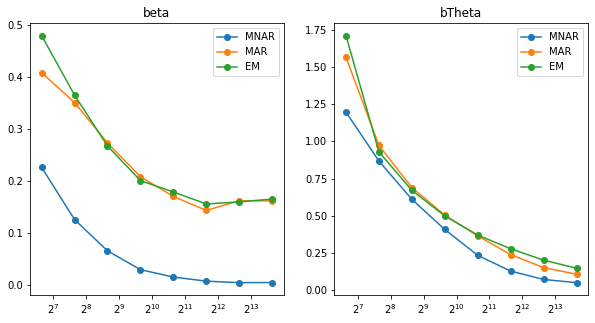

In [20]:
ns = [100, 200, 400, 800, 1600, 3200, 6400, 12800]
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.title("beta")
plt.plot(ns, errMNARmean[:, 0], "-o", label="MNAR")
plt.plot(ns, errMARmean[:, 0], "-o", label="MAR")
plt.plot(ns, errEMmean[:, 0], "-o", label="EM")
plt.xscale("log", base=2)
plt.legend()

plt.subplot(122)
plt.title("bTheta")
plt.plot(ns, (errMNARmean[:, 1]), "-o", label="MNAR")
plt.plot(ns, (errMARmean[:, 1]), "-o", label="MAR")
plt.plot(ns, errEMmean[:, 1], "-o", label="EM")
plt.xscale("log", base=2)
plt.legend()

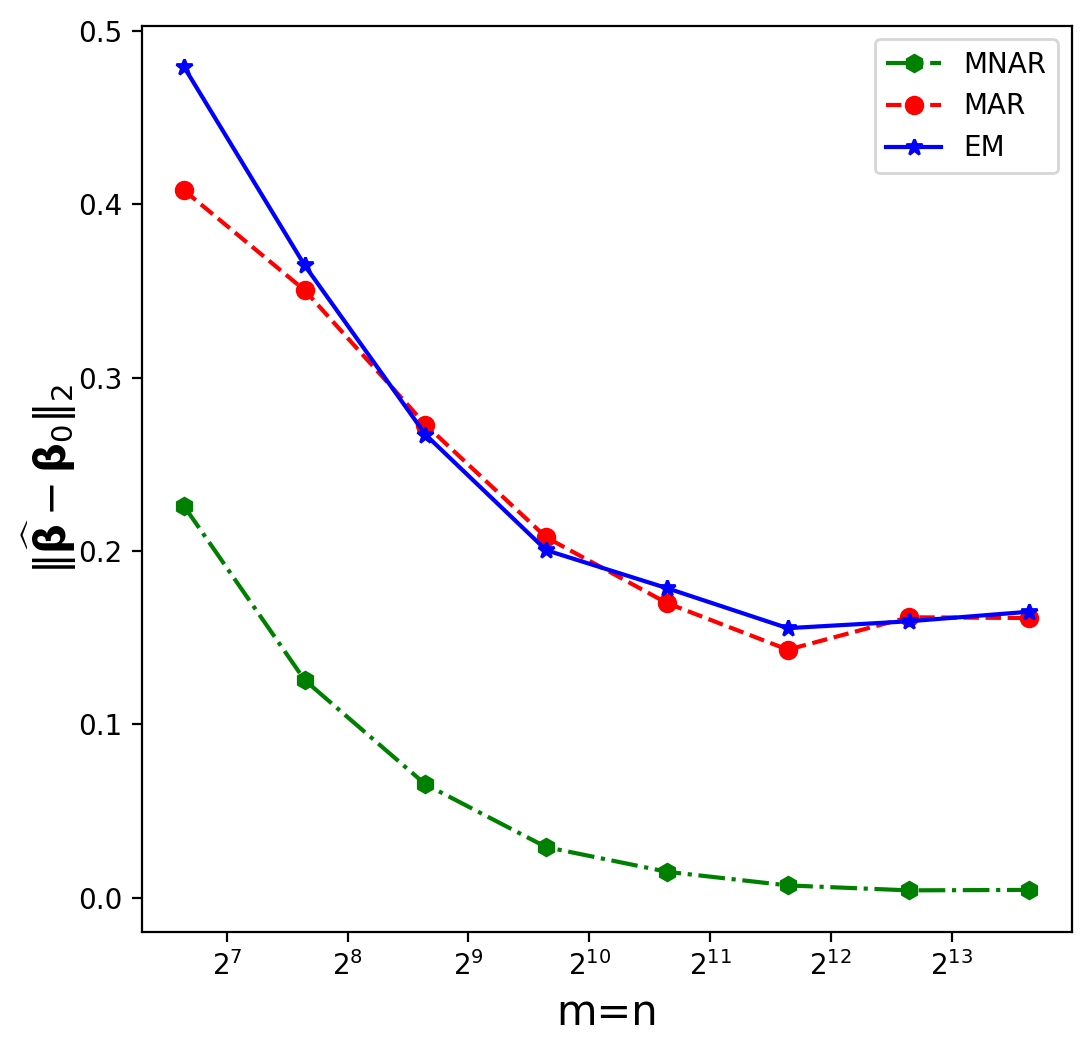

In [24]:
ns = [100, 200, 400, 800, 1600, 3200, 6400, 12800]
plt.figure(figsize=[6, 6], dpi=200)
font_y = {"size": 15, "va":"baseline"}
font_x = {"size": 15}
plt.xlabel("m=n", font_x)
plt.ylabel(r"$\Vert\widehat{\mathbf{\beta}} - \mathbf{\beta}_0\Vert_2$", font_y)
plt.plot(ns, errMNARmean[:, 0], "g-.h", label="MNAR")
plt.plot(ns, errMARmean[:, 0], "r--o", label="MAR")
plt.plot(ns, errEMmean[:, 0], "b-*", label="EM")
plt.xscale("log", base=2)
plt.legend()
plt.savefig("./JMLRR2/Logip2beta.jpg", bbox_inches='tight')

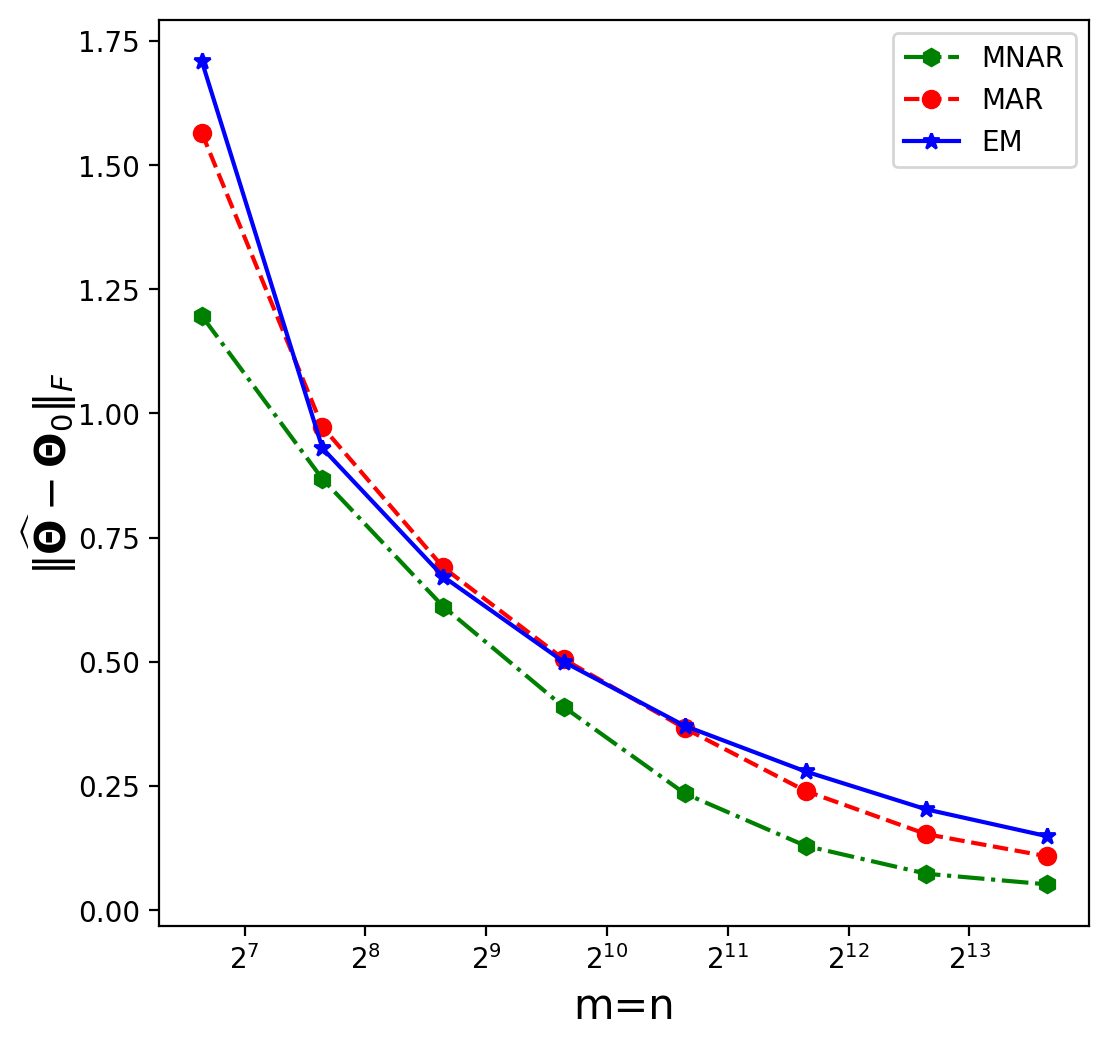

In [25]:
ns = [100, 200, 400, 800, 1600, 3200, 6400, 12800]
plt.figure(figsize=[6, 6], dpi=200)
font_y = {"size": 15, "va":"baseline"}
font_x = {"size": 15}
plt.xlabel("m=n", font_x)
plt.ylabel(r"$\Vert\widehat{\mathbf{\Theta}} - \mathbf{\Theta}_0\Vert_F$", font_y)
plt.plot(ns, errMNARmean[:, 1], "g-.h", label="MNAR")
plt.plot(ns, errMARmean[:, 1], "r--o", label="MAR")
plt.plot(ns, errEMmean[:, 1], "b-*", label="EM")
plt.xscale("log", base=2)
plt.legend()
plt.savefig("./JMLRR2/Logip2theta.jpg", bbox_inches='tight')